# Stock Close Prediction Technical Indicator Recommender System

**Team Lead**: James Guzman

**Teammates**: Josef, Anshul

**Project Advisor**: Dr. Magdalini Eirinaki

**SJSU CMPE 256**: Advanced Data Mining

**Date**: Nov 25, 2023

https://www.kaggle.com/code/josefbustamante/cmpe256-group-project

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import ta
import math
import warnings

In [2]:
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
# from catboost import CatBoostRegressor
# from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, r2_score
from pathlib import Path

In [3]:
# import tensorflow as tf
# warnings.filterwarnings('ignore')
# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *

In [4]:
device = torch.device("cuda")

## We can recommend by certain criteria

Risk Profile: Assess the risk associated with the stock/ETF, considering factors like volatility, beta, standard deviation, and historical performance. Investors have different risk tolerances, so offering a range of risk profiles can cater to varying preferences.

Performance Metrics: Analyze historical returns, Sharpe ratio, alpha, beta, and other performance metrics to gauge the past performance and potential future returns.

Industry/ Sector: Segment stocks/ETFs based on industries or sectors they belong to. Some investors may prefer exposure to specific sectors (tech, healthcare, energy, etc.) due to their understanding or belief in their growth potential.

Diversification: Provide recommendations that aid in diversifying a portfolio across different industries, regions, or asset classes. Diversification helps mitigate risk.

Market Trends and Sentiment Analysis: Incorporate sentiment analysis by tracking news sentiment, social media chatter, and expert opinions to gauge market trends and sentiment toward particular stocks/ETFs.

Fundamental Analysis: Consider fundamental factors such as earnings, revenue growth, profit margins, debt levels, P/E ratios, and other financial metrics to assess the underlying strength of the company.

Technical Analysis: For traders interested in technical indicators, consider metrics like moving averages, RSI (Relative Strength Index), MACD (Moving Average Convergence Divergence), etc., to evaluate entry and exit points.

Liquidity and Volume: Include stocks/ETFs with sufficient liquidity and trading volume, as low liquidity can impact trade execution and pricing.

Costs and Fees: Consider expense ratios, trading fees, and other costs associated with investing in the recommended stocks/ETFs.

User Preferences and Constraints: Take into account individual user preferences, investment goals, time horizon, tax considerations, and any constraints or ethical considerations they might have.

Regulatory and Legal Factors: Ensure compliance with regulatory requirements and ethical standards related to investment recommendations.

Adaptability and Learning: Implement a system that continuously learns from user feedback and adapts recommendations based on the changing market conditions and user preferences.

Performance Against Benchmarks: Compare the recommended stocks/ETFs against relevant benchmarks (like S&P 500, sector-specific indices) to provide a benchmark-relative assessment.

## Import Data

In [5]:
# Write the CSV file
home_dir = os.environ["HOME"]
symbols_metadata_df = pd.read_csv(f'{home_dir}/src/sjsu/Stock-Recommender-System/myStock-wave-app/database/seed/NASDAQ_Yahoo_Finance/symbols_valid_meta.csv')

url = "https://en.wikipedia.org/wiki/Nasdaq-100"
nasdaq100_meta = pd.read_html(url)[4]
# nasdaq100_meta.to_csv(f"{home_dir}/src/sjsu/Stock-Recommender-System/myStock-wave-app/database/seed/NASDAQ_Yahoo_Finance/nasdaq100_meta.csv", index=False)

In [6]:
etf_csv_files = glob.glob(f"{home_dir}/src/sjsu/Stock-Recommender-System/myStock-wave-app/database/seed/NASDAQ_Yahoo_Finance/etfs/*.csv")

stock_csv_files = glob.glob(f"{home_dir}/src/sjsu/Stock-Recommender-System/myStock-wave-app/database/seed/NASDAQ_Yahoo_Finance/stocks/*.csv")

etf_dfs = {}
stock_dfs = {}

for etf_csv_filename in etf_csv_files:
    df = pd.read_csv(etf_csv_filename, index_col=None, header=0)
    etf_dfs[Path(etf_csv_filename).stem] = df
    
for stock_csv_filename in stock_csv_files:
    df = pd.read_csv(stock_csv_filename, index_col=None, header=0)
    stock_dfs[Path(stock_csv_filename).stem] = df
    
stock_dfs['A'] # Example of how you would access a dataframe for a particular ticker
print("Count of PDs for each ticker: " + str(len(stock_dfs))) 

Count of PDs for each ticker: 5884


In [7]:
stock_dfs['A'] = pd.read_csv(f"{home_dir}/src/sjsu/Stock-Recommender-System/myStock-wave-app/database/seed/NASDAQ_Yahoo_Finance/stocks/A.csv", index_col=None, header=0)

In [8]:
stock_dfs['A'].head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,27.068665,62546300
1,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.838577,15234100
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.068665,6577800
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.607880,5975600
4,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.261524,4843200


## Define helper functions for analyzing data

In [9]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        hist, edges = np.histogram(df[var_name], bins=10)
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( edges , visible=True )
        ax.set_yticklabels( [] , visible=True )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    df = df.select_dtypes(['number'])
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

## Helper Classes & Functions

In [10]:
def mkdir_prep_dir(dirpath):
    """make preprocess directory if doesn't exist"""
    prep_dir = dirpath
    if not os.path.exists(prep_dir):
        os.makedirs(prep_dir)
    return prep_dir

def save_checkpoint(state, filename="best_lstm.pth.tar"):
    print("=> Saving Checkpoint")
    torch.save(state, filename)

def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

# Based on perplexity.ai solution to torchmetrics.functional f1 lib incompatibility
# https://www.perplexity.ai/search/Stock-Recommender-System-BY7xxwMfT9Ohxqz5klk1BA?s=c
def f1_score(y_pred, y_true):
    epsilon = 1e-7
    tp = (y_true * y_pred).sum().to(torch.float32)
    fp = ( (1 - y_true) * y_pred ).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    return f1

In [11]:
class NasdaqDataset(torch.utils.data.Dataset):
    def __init__(self, closing_price_2d_list, final_closing_price_list):
        self.closing_price_2d_list_ = closing_price_2d_list
        self.final_closing_price_list_ = final_closing_price_list
        self.count_ = 0

    def __len__(self):
        return len(self.closing_price_2d_list_)

    def __getitem__(self, idx):
        if DEBUG and self.count_ == 0:
            print(f"NasdaqDataset __getitem__ idx = {idx}")
        # each array holds 100 days of closing prices
        closing_price_array = self.closing_price_2d_list_[idx]
        closing_price_tensor = torch.tensor(closing_price_array).float()

        if DEBUG and self.count_ == 0:
            print(f"closing_price_tensor.shape = {closing_price_tensor.shape}")
        
        final_closing_price_array = self.final_closing_price_list_[idx]
        final_closing_price_tensor = torch.tensor(final_closing_price_array).float()

        if DEBUG and self.count_ == 0:
            print(f"final_closing_price_tensor.shape = {final_closing_price_tensor.shape}")

        self.count_ += 1
        
        return closing_price_tensor, final_closing_price_tensor

## Data Analysis NASDAQ Stock Metadata

In [12]:
symbols_metadata_df

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100.0,N,NaN,AA,AA,N
2,Y,AAAU,Perth Mint Physical Gold ETF,P,,Y,100.0,N,NaN,AAAU,AAAU,N
3,Y,AACG,ATA Creativity Global - American Depositary Sh...,Q,G,N,100.0,N,N,NaN,AACG,N
4,Y,AADR,AdvisorShares Dorsey Wright ADR ETF,P,,Y,100.0,N,NaN,AADR,AADR,N
...,...,...,...,...,...,...,...,...,...,...,...,...
8044,Y,ZUO,"Zuora, Inc. Class A Common Stock",N,,N,100.0,N,NaN,ZUO,ZUO,N
8045,Y,ZVO,Zovio Inc. - Common Stock,Q,Q,N,100.0,N,N,NaN,ZVO,N
8046,Y,ZYME,Zymeworks Inc. Common Shares,N,,N,100.0,N,NaN,ZYME,ZYME,N
8047,Y,ZYNE,"Zynerba Pharmaceuticals, Inc. - Common Stock",Q,G,N,100.0,N,N,NaN,ZYNE,N


In [13]:
symbols_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8049 entries, 0 to 8048
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nasdaq Traded     8049 non-null   object 
 1   Symbol            8049 non-null   object 
 2   Security Name     8049 non-null   object 
 3   Listing Exchange  8049 non-null   object 
 4   Market Category   8049 non-null   object 
 5   ETF               8049 non-null   object 
 6   Round Lot Size    8049 non-null   float64
 7   Test Issue        8049 non-null   object 
 8   Financial Status  3383 non-null   object 
 9   CQS Symbol        4666 non-null   object 
 10  NASDAQ Symbol     8049 non-null   object 
 11  NextShares        8049 non-null   object 
dtypes: float64(1), object(11)
memory usage: 754.7+ KB


<Axes: xlabel='count', ylabel='Financial Status'>

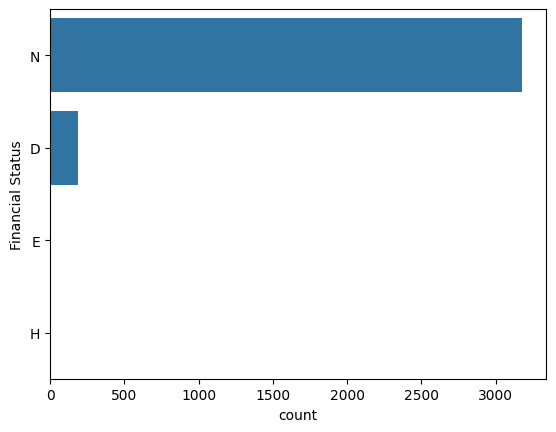

In [14]:
sns.countplot(symbols_metadata_df["Financial Status"])

<Axes: xlabel='count', ylabel='Nasdaq Traded'>

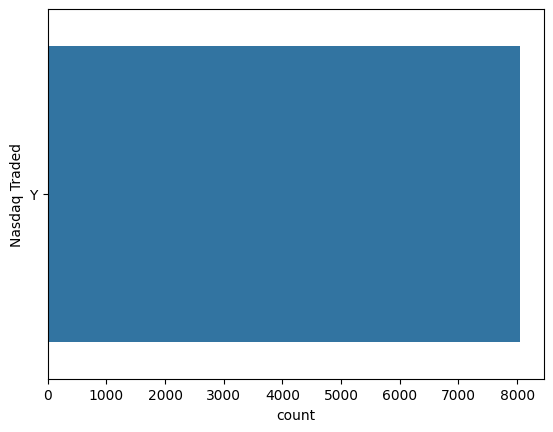

In [15]:
sns.countplot(symbols_metadata_df["Nasdaq Traded"])

<Axes: xlabel='count', ylabel='Listing Exchange'>

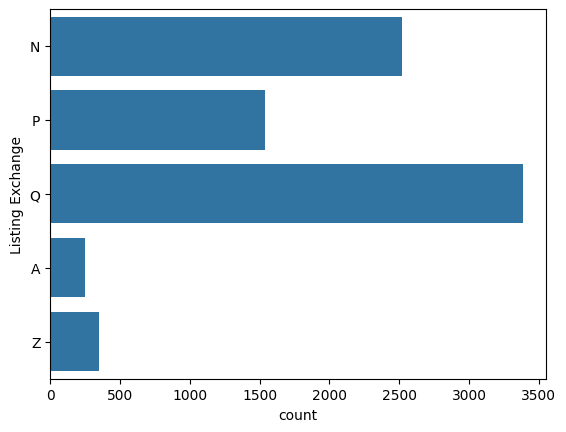

In [16]:
sns.countplot(symbols_metadata_df["Listing Exchange"])

<Axes: xlabel='count', ylabel='GICS Sector'>

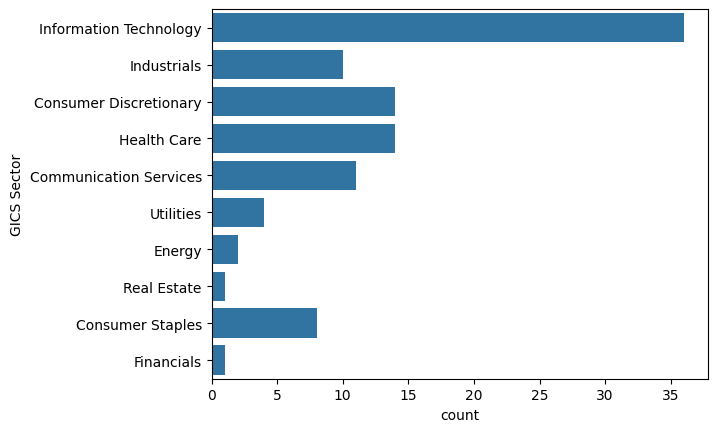

In [17]:
sns.countplot(nasdaq100_meta["GICS Sector"])
# plt.xlabel("0 – Not looking for job change, 1 – Looking for a job change")
# plt.ylabel("Count")

<Axes: xlabel='count', ylabel='GICS Sub-Industry'>

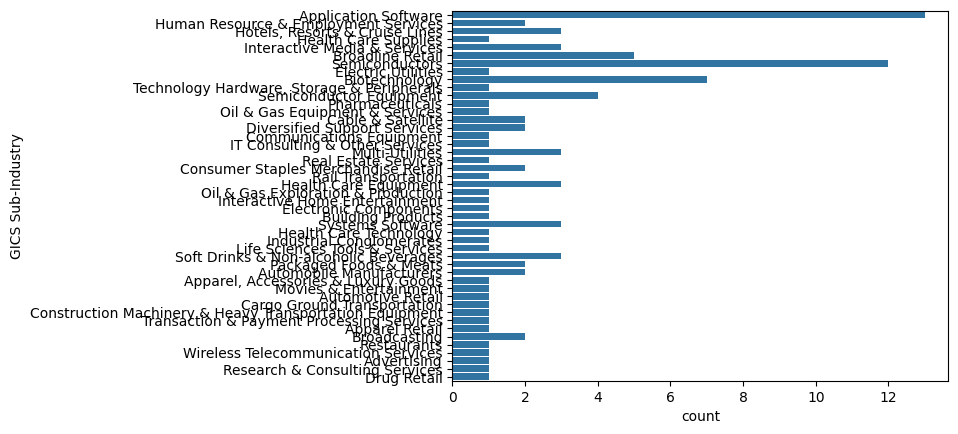

In [18]:
sns.countplot(nasdaq100_meta["GICS Sub-Industry"])
# plt.xlabel("0 – Not looking for job change, 1 – Looking for a job change")
# plt.ylabel("Count")

## Data Analysis NASDAQ Stock Data

In [19]:
tickers = ['AAPL', 'ACH', 'ACGL', 'ACER', 'ABT', 'GOOGL']

In [20]:
stock_dir_path = "/home/james/src/datasets/NASDAQ_Yahoo_Finance/stocks"
symbol_name = "GOOGL"
if symbol_name in symbols_metadata_df["Symbol"].tolist():
    print(f"{symbol_name} is in NASDAQ Yahoo Finance Metadata, loading GOOGL stock pd")
    google_stock_data_pd = pd.read_csv(os.path.join(stock_dir_path, f"{symbol_name}.csv"))

GOOGL is in NASDAQ Yahoo Finance Metadata, loading GOOGL stock pd


In [21]:
google_stock_data_pd.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000
1,2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300
2,2004-08-23,55.430431,56.796795,54.579578,54.754753,54.754753,18256100
3,2004-08-24,55.675674,55.855854,51.836838,52.487488,52.487488,15247300
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188600


In [22]:
google_stock_data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3932 entries, 0 to 3931
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3932 non-null   object 
 1   Open       3932 non-null   float64
 2   High       3932 non-null   float64
 3   Low        3932 non-null   float64
 4   Close      3932 non-null   float64
 5   Adj Close  3932 non-null   float64
 6   Volume     3932 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 215.2+ KB


## Create Moving Average Stock Across 100 Days

Visualize one sample GOOGL stock ticker and then save csv of both moving average 100 and closing prices for stock tickers from our list, we'll use to bootstrap our app.

In [23]:
dataset_name = "stock_closing_price"
num_days = 100

In [24]:
mkdir_prep_dir("stock_closing_price/data_explore/plots")
mkdir_prep_dir("stock_closing_price/data_explore/mavg100_close_price")

'data_explore/csvs'

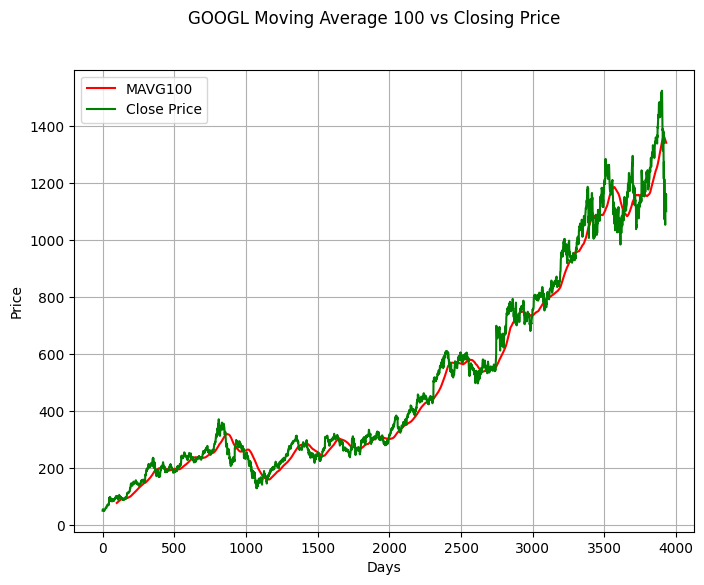

In [26]:
mavg_100_days = google_stock_data_pd.Close.rolling(num_days).mean()
plt.figure(figsize=(8, 6))
plt.suptitle("GOOGL Moving Average 100 vs Closing Price")
plt.plot(mavg_100_days, "r", label="MAVG100")
plt.plot(google_stock_data_pd.Close, "g", label="Close Price")
plt.xlabel("Days")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.savefig("plots/data_prep/mavg100_closeprice.jpg")
plt.show()

In [27]:
def save_close_price_mavg(stock_close_prices, mavg_n_days_close_prices, dst_folder="plots/data_prep/csv", filename="mavg_vs_close_prices.csv"):
    mkdir_prep_dir(f"{dst_folder}")
    dst_filepath = f"{dst_folder}/{filename}"

    # final close price pred for each 100th date after predicting on 100 days of final closing prices
    stock_close_price_res_df = pd.DataFrame({"Close": stock_close_prices, "MAVG": mavg_n_days_close_prices})
    stock_close_price_res_df.to_csv(dst_filepath, index=False)
    return stock_close_price_res_df

In [28]:
# Save At least 5 company tickers in data explore folder
for ticker_stock in tickers:
    mavg_100_days = stock_dfs[ticker_stock].Close.rolling(num_days).mean()
    stock_close_prices = stock_dfs[ticker_stock].Close
    save_close_price_mavg(stock_close_prices, mavg_100_days,
                          dst_folder=f"stock_closing_price/data_explore/mavg100_close_price", 
                          filename=f"{ticker_stock}_mavg100_vs_close_prices.csv")

## Hyperparameters

In [16]:
LEARNING_RATE = 1e-2
BATCH_SIZE = 16
TEST_BATCH_SIZE = 1
NUM_EPOCHS = 10
DEBUG = True

# dataset_name = "stock_closing_price"

device = torch.device("cuda")
print(f"Running on GPU {torch.cuda.get_device_name(device)}")

Running on GPU NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [17]:
train_mse_loss_avg_values = []
train_rmse_loss_avg_values = []
train_f1_avg_values = []

valid_mse_loss_avg_values = []
valid_rmse_loss_avg_values = []
valid_f1_avg_values = []